
# **Variational Quantum Circuits: VQE, QAOA**

Wenyang Qian (qian.wenyang@usc.es), IGFAE      
   
March 7th, 2025   


<div class="alert alert-block alert-success">

**Read me before you start**  
    
There are 18 mini-exercises (marked in Green) in total in this Jupyter notebook:

Part 1. Simulating Time Evolution with Quantum Circuit (Exercises 1-4)

Part 2. Extracting Observable from Measurement (Exercises 5)

Part 3. The Maxcut Problem (Exercises 6-7)

Part 4. Building Variational Quantum Eigensolvers to Solve the Maxcut Problem (Exercises 8-11)

Part 5. Building Quantum Approximation Optimization Algorithm to Solve the Maxcut Problem (Exercises 12-15)

Most of the exercises are very straightforward, with solutions in one or two lines. Be free to ask your mentors and discss with your classmates.
    
</div>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import transpile
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import LieTrotter, SuzukiTrotter
from qiskit.quantum_info import Pauli, SparsePauliOp
from qiskit.visualization import plot_histogram
from qiskit.primitives import Estimator, Sampler, StatevectorEstimator, StatevectorSampler
import qiskit_aer
import qiskit_algorithms
import qiskit

print('Qiskit version:', qiskit.version.get_version_info())

Qiskit version: 1.3.0


## Part 1. Simulating Time Evolution with Quantum Circuit

In this part, you will learn the basic tools to simulate quantum circuit for some time evolution operator $\exp(-iHt)$. 

In most cases, our Hamiltonian $H$ is mapped onto quantum circuits as Pauli operators (Pauli matrices). We will first look at how to build Pauli operator using *Qiskit*.

<div class="alert alert-block alert-success">

### **Understanding Pauli Operator and their basic operations**  
    
Follow the examples and guides below to understand how to use *SparsePauliOp* class to build any Pauli operators.
    
You can read more about *SparsePauliOp* class [here](https://qiskit.org/documentation/stubs/qiskit.quantum_info.SparsePauliOp.html)
</div>

Firstly, we can build simple one-qubit Pauli operators as follows.

In [2]:
X = SparsePauliOp('X')
Y = SparsePauliOp('Y')
Z = SparsePauliOp('Z')
I = SparsePauliOp('I')

print("Pauli-X operator:")
print(X.to_matrix())
print("\nPauli-Y operator:")
print(Y.to_matrix())
print("\nPauli-Z operator:")
print(Z.to_matrix())
print("\nPauli-I operator:")
print(I.to_matrix())

Pauli-X operator:
[[0.+0.j 1.+0.j]
 [1.+0.j 0.+0.j]]

Pauli-Y operator:
[[0.+0.j 0.-1.j]
 [0.+1.j 0.+0.j]]

Pauli-Z operator:
[[ 1.+0.j  0.+0.j]
 [ 0.+0.j -1.+0.j]]

Pauli-I operator:
[[1.+0.j 0.+0.j]
 [0.+0.j 1.+0.j]]


Make sure you check these single-qubit Pauli operators in matrix form and it should agree with your expectation.

It is very important to know how to manipulate Pauli operators. Here are exacmples of the major Pauli arithmetic operations you need to know for constructing more interesting Pauli operators.

<div class="alert alert-block alert-success">

(a) **Tensor Product**  
    
To build a Multiple-qubit Pauli Operators, we typically use tensor product of individual Pauli Operators. In *Qiskit*, one uses $^$ symbol to concatenate individual Pauli Operators. See the examples below.

</div>

Example 1: 4-qubit tensor product, $I \otimes X\otimes Y \otimes Z$

In [3]:
I^X^Y^Z

SparsePauliOp(['IXYZ'],
              coeffs=[1.+0.j])

Example 2: One can also directly build a tensor product using the class initialization.

In [4]:
SparsePauliOp("IXYZ")

SparsePauliOp(['IXYZ'],
              coeffs=[1.+0.j])

<div class="alert alert-block alert-success">
Note, Qiskit used a reversed notation, so it is actually $I_3 \otimes X_2\otimes Y_1 \otimes Z_0$. The qubit index also starts with zero.
</div>


<div class="alert alert-block alert-success">

(b) **Scalar Product** 

To build a scalar product of Pauli Operators, we need to use the $*$ symbol between the scalar and the Pauli operator.
</div>

Example 1: 4-qubit tensor product, $4 I \otimes X\otimes Y \otimes Z$

In [5]:
4*I^X^Y^Z

SparsePauliOp(['IXYZ'],
              coeffs=[4.+0.j])

Example 2: One can also directly build it using the class initialization by specifying both Pauli strings and scalar coefficients.

In [6]:
SparsePauliOp("IXYZ", coeffs=4)

SparsePauliOp(['IXYZ'],
              coeffs=[4.+0.j])

<div class="alert alert-block alert-success">

(c) **Linear Combinations of Pauli Operators**

Often, we need to deal with a sum of Pauli operators, i.e., a linear combintation. You will use the $+$ symbol to write a linear combination of the Pauli operators. 

Note: only Pauli operators of the same number of qubits can be joined. Parenthesis are needed for grouping different components.
</div>

Example 1: 4-qubit linear combinations, $X\otimes X\otimes I \otimes I + 2I \otimes Y\otimes  Y\otimes I + 3I \otimes I\otimes  Z\otimes Z$

In [7]:
(X^X^I^I) + 2*(I^Y^Y^I) + 3*(I^I^Z^Z)

SparsePauliOp(['XXII', 'IYYI', 'IIZZ'],
              coeffs=[1.+0.j, 2.+0.j, 3.+0.j])

Example 2: One may also build it directly.

In [8]:
SparsePauliOp(["XXII", "IYYI", "IIZZ"], coeffs=[1,2,3])

SparsePauliOp(['XXII', 'IYYI', 'IIZZ'],
              coeffs=[1.+0.j, 2.+0.j, 3.+0.j])

<div class="alert alert-block alert-success">

(d) **Product of Pauli Operators**

*SparsePauliOp* class really shines when you want to compute qubitwise product of pauli operators. Mathematically, this is what we refer to as matrix multiplication. For that, we will use the $@$ symbol. 

In the example below, you can see it supports algebraic expression and knows Pauli matrix properties. The final result can be further simplified with *.simplify()* method.

</div>

Example 1: Contructing an interesting Pauli operator, $4 (X_1Y_0+Y_1X_0)^2$

In [9]:
op1 = X^Y
op2 = Y^X

res = 4*(op1 + op2) @ (op1 + op2)

print(res)

SparsePauliOp(['II', 'ZZ', 'ZZ', 'II'],
              coeffs=[4.+0.j, 4.+0.j, 4.+0.j, 4.+0.j])


In [10]:
print('Sum of product after applying simplify() method:')
print(res.simplify())

Sum of product after applying simplify() method:
SparsePauliOp(['II', 'ZZ'],
              coeffs=[8.+0.j, 8.+0.j])


Do they agree with each other before and after simplification?

<div class="alert alert-block alert-success">

### **Exercise 1. Building Multi-qubit Pauli Operator**  
    
Now that you have learned about the Pauli Operators, here is an exercise. 

Let us build Pauli Operator $$H_{sw} = \frac{1}{2}(I_0I_1+X_0X_1 + Y_0Y_1+ Z_0Z_1)$$ using your X, Y, Z, I variables defined above. Or you can use *SparsePauliOp* directly from the list of Paulis.
</div>

In [11]:
##### ==================================
# Write your solution in here.
H_sw = ((I^I) + (X^X) + (Y^Y) + (Z^Z))/2
##### ==================================

print(H_sw)

SparsePauliOp(['II', 'XX', 'YY', 'ZZ'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j])


Great, now you have build an important quantum operator. You will see in a few more steps.

<div class="alert alert-block alert-success">

In class, we learned how to simulate any time evolution operators $\exp(-iHt)$ that is made up of many Pauli terms. Let us briefly recall,

* Simplify $H$ into disjoint, commuting Pauli terms.
* Ultilize different Trotter formulas, such as Lie-Trotter to linear order, to approximate the expression.
* Build towers of Rz (Rotation Z gate) and CX (Control-Not gate) for purely Pauli-Z based operator
* Prepend and Append H, or SH gates for Pauli-X and Pauli-Y based operators.
* The coefficients naturally appear in the Rz rotation angle.

In general it is very complicated. Luckily, with Qiskit, you do not worry about it. All these can be easily constructed using *PauliEvolutionGate* class. (there are also many more classes)

</div>


See an example below, to construct a two-qubit $\exp\big[-i (XY) t\big]$ for t = 1.5 seconds.

In [12]:
peg = PauliEvolutionGate(operator=(X^Y), time=1.5)
peg

Instruction(name='PauliEvolution', num_qubits=2, num_clbits=0, params=[1.5])

Note *PauliEvolutionGate* is only quantum circuit instructions. To build it into an actual quantum circuit, you will need to append these instruction to the main quantum circuit, for example below

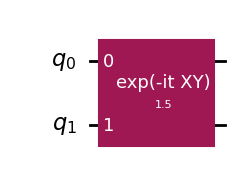

In [13]:
qc = QuantumCircuit(2) # our main circuit
qc.append(peg, [0, 1]) 
# [0, 1] indicates the location of the appending operation. 
# Here, it is qubit-0 to qubit-0 and qubit-1 to qubit-1
# as you can see in the circuit, 0 is connected to 0, 1 is connected to 1
qc.draw(output='mpl')

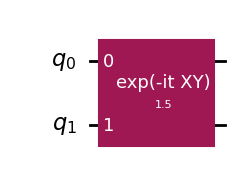

In [14]:
qc = QuantumCircuit(2) # our main circuit
qc.compose(peg, inplace=True) 
# alternatively, one could also use "compose" to join circuits
# inplace=True means modification on the original circuit
qc.draw(output='mpl')

<div class="alert alert-block alert-success">

### **Exercise 2. Building Quantum Circuit to Simulate Time Evolution Operator**  
    
With the above examples, let us write a generic function that takes in any Pauli operator $H$ and an evolution time $t$, and returns the quantum circuit for $\exp(-i H t)$. 

Then, try use your function to build the time evolution circuit of your previous Hamiltonian $H_{sw}$. 
</div>

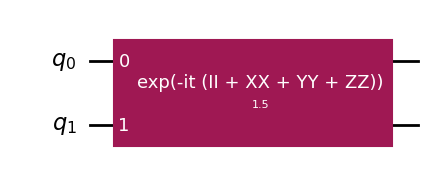

In [15]:
def time_evolve(operator, time):
    num_qubit = operator.num_qubits
    qc = QuantumCircuit(num_qubit)
    ##### ==================================
    # Write your solution in here.    
    peg = PauliEvolutionGate(operator, time=time, synthesis=LieTrotter())
    qc.append(peg, range(num_qubit))
    ##### ==================================
    return qc

# Test your circuit
qc = time_evolve(H_sw, 1.5)
qc.draw(output='mpl')

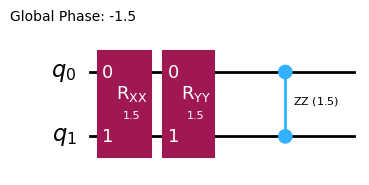

In [16]:
# decompose to see the component
qc.decompose().draw(output='mpl')

You should see 4 Pauli exponential blocks here. Why? Because all these Pauli terms are commutative. So, we can simulate them blockwise and without error!

But then you may ask, how do we verify them individually and see the tower structure of CX gates and RZ gates we saw in class?

<div class="alert alert-block alert-success">

Transpiling Quantum Circuit to Specified Gate Sets
    
There are more than one ways to decompose the quantum circuit. We need to transpile the quantum circuits to the specific basis gates that we are assigning them.

Introducing the *transpile* function, which takes a quantum circuit and a list of basis gates. Now, transpile your quantum circuit to basis gates "h", "s", "sdg", "rz", "cx". Does it match your expectation?
</div>

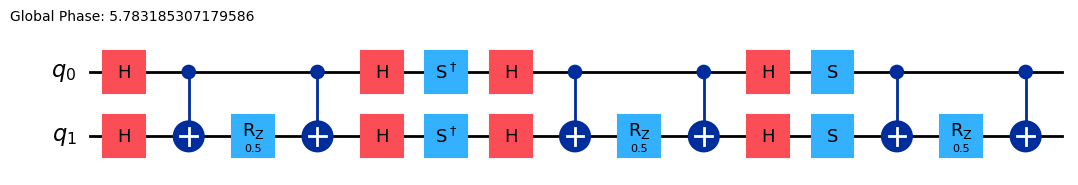

In [17]:
qc = time_evolve(H_sw, 0.5)

transpiled_qc = transpile(qc, basis_gates=['id', 'rz', 's', 'sdg', 'h', 'cx'], optimization_level=1)
transpiled_qc.draw(output='mpl')

Note, you should try to identify **three** towers of Rz gates with CXs. 

The $\exp(-iIIt)=\cos(t) II - i \sin(t) II = \Big(cos(t)-i\sin(t)\Big) II$ becomes part of the global phase that is proportional to the evolution time. Note the Global phase is already computed by *Qiskit*, so that part of the circuit is skipped.

<div class="alert alert-block alert-success">

### **Exercise 3. Building a Quantum Circuit with Initialization and Measurement**  
    
Before simulating your quantum circuit, we need to add an initialization block and a measurement block.
    
To make things interesting, try initialize qubit-0 as $|1\rangle$, qubit-1 as $|0\rangle$ state, and then time evolve your $H_{sw}$ for $\pi/2$ period, and finally add a measurement block.

    
</div>

Example 1: Applying an X gate on the 0th qubit and H gate on the 1st qubit of a quantum circuit, and then measure all qubits.

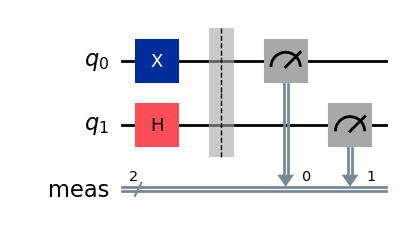

In [18]:
qc = QuantumCircuit(2)
qc.x(0)  # apply x to 0th qubit
qc.h(1)  # apply h to 1st qubit
qc.measure_all() # final measurement
qc.draw(output="mpl")

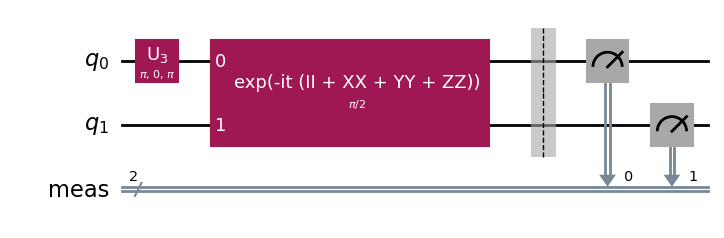

In [19]:
qc = QuantumCircuit(2)
##### ==================================
# Write your solution in here.
# 1. Initialize qubit_0 as |1>, qubit_1 as |0> state
qc.x(0)

# 2. Time evolve for t = pi/2, using your function *time_evolve* 
qc.append(time_evolve(H_sw, np.pi/2), [0, 1])

# 3. Measure all
qc.measure_all()
##### ==================================
qc.decompose().draw(output='mpl')

Now we have a complete circuit!


<div class="alert alert-block alert-success">

### **Exercise 4. Simulate with Ideal Shot-based Simulator**     
    
Let us simulate your quantum circuit with the ideal shot-based simulator, which means there are no quantum noises except for the statisitic uncertainties.

There are many ways to do it in Qiskit, I wrote one using *StatevectorSampler* class (working for Qiskit 1.3)
    
Try to run different number of shots, 10, 100, 100, 1000. What do you observe?
</div>

In [20]:
def sample_with_shots(circuit, shots, num_qubits, export_prob=True):
    ''' Using StatevectorSampler class from Qiskit 1.3 
        Ref: https://docs.quantum.ibm.com/api/qiskit/qiskit.primitives.StatevectorSampler
    '''
    shot_sampler = StatevectorSampler(default_shots=shots)
    pub = (circuit)
    job = shot_sampler.run([pub], shots=shots)
    counts = job.result()[0].data.meas.get_counts()
    probs = {k: v/shots for k, v in counts.items()}
    return probs if export_prob else counts

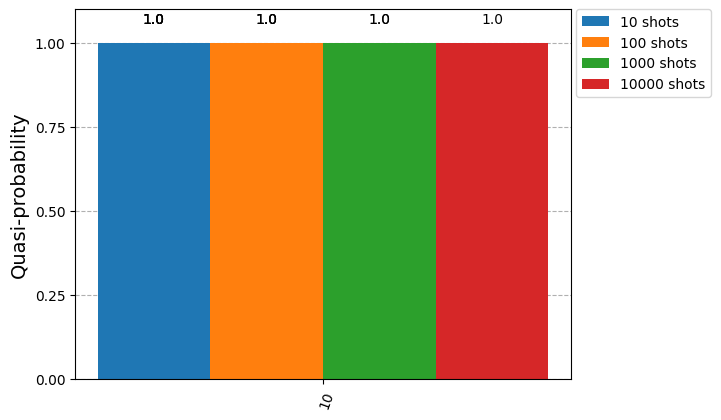

In [21]:
num_qubits = 2
##### ==================================
# Write your solution in here.
# Try write each one with the type of sample function
dist_10    = sample_with_shots(qc, 10, num_qubits)
dist_100   = sample_with_shots(qc, 100, num_qubits)
dist_1000  = sample_with_shots(qc, 1000, num_qubits)
dist_10000 = sample_with_shots(qc, 10000, num_qubits)
##### ==================================

dist_list = [dist_10, dist_100, dist_1000, dist_10000]

plot_histogram(dist_list, legend=["10 shots", "100 shots", "1000 shots", "10000 shots"])

Since we started with $|q_1q_0\rangle = |01\rangle$ state, you will see the result in **any shot** is now a $|10\rangle$ state. 

Yes, that is right. You have just implemented a SWAP gate. There are many implementations of SWAP gates. Here, you simulate a SWAP gate by $\exp(-i\frac{(II+XX+YY+ZZ)}{2}\theta)$ with an angle $\theta=\pi/2$, which your simulation time here.

Now, what will happen if you try to rotate only half the angle? What do you think will happen.


<div class="alert alert-block alert-success">
    
Now we change the evolution time to $\pi/4$. What do you see?
    
Try to run different number of shots, 10, 100, 100, 1000. What do you observe?
</div>

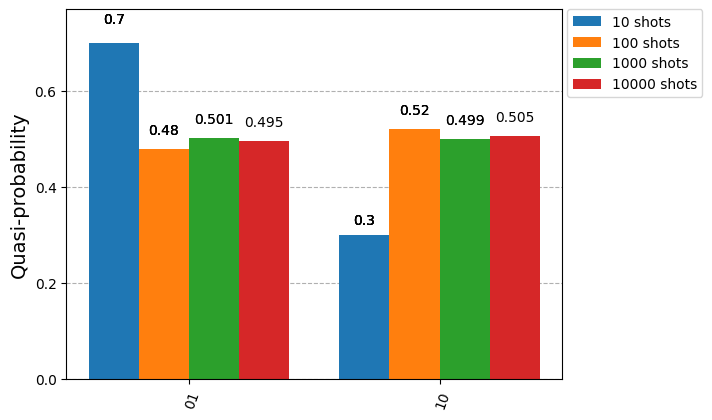

In [22]:
qc = QuantumCircuit(2)
##### ==================================
# 1. Initialize qubit_0 as |1>, qubit_1 as |0> state
qc.x(0)

# 2. Time evolve for t = pi/4
qc.append(time_evolve(H_sw, np.pi/4), [0, 1])

# 3. Measure all
qc.measure_all()
##### ==================================
num_qubits = 2

dist_10 = sample_with_shots(qc, 10, num_qubits)
dist_100 = sample_with_shots(qc, 100, num_qubits)
dist_1000 = sample_with_shots(qc, 1000, num_qubits)
dist_10000 = sample_with_shots(qc, 10000, num_qubits)

dist_list = [dist_10, dist_100, dist_1000, dist_10000]

plot_histogram(dist_list, legend=["10 shots", "100 shots", "1000 shots", "10000 shots"])


Since we rotate only half the angle, it should be an even superposition of $|01\rangle$ and $|10\rangle$ states right? 

With the number of shots going larger and larger, the probability distributions should be 0.5 for each.

In practice, this is very important property, with different angles, you can generate desire weighted sum of these one-hot encoded bitstrings, which has many applications especially in quantum machine learning and combinatorial problems.

## Part 2. Extracting Observables

<div class="alert alert-block alert-success">

### **Exercise 5. Building Pauli Observables**  
    
We have talked about simulating time evolution Hamiltonian. We will now switch to discussing extracting observables from the quantum circuit. 

Let us first build a Pauli observable that we want to measure. Try build a Pauli operator 
$$ O_{diff} = \frac{1}{2}\Big((I-Z)\otimes I - I\otimes (I-Z)\Big) $$
    
After you finish, predict what you get if measuring this observable for the distribution above?
    
Remember $\frac{(I-Z)}{2}|0\rangle = 0|0\rangle=0$ and $\frac{(I-Z)}{2}|1\rangle = 1|1\rangle$. Convince yourself that this observable counts the difference of the 1's in the two qubits.
</div>

In [23]:
##### ==================================
# Write your solution in here.
O_diff = ((I-Z)^I)/2 - (I^(I-Z))/2
##### ==================================
O_diff

SparsePauliOp(['II', 'ZI', 'II', 'IZ'],
              coeffs=[ 0.5+0.j, -0.5+0.j, -0.5+0.j,  0.5-0.j])

<div class="alert alert-block alert-success">
    
Extracting observables on the quantum circuit is very easy thanks to *Estimator* class. It is very similar to *Sampler* class. I have written this function *estimate_with_shots* and *estimate_with_shots_v2* for you.

The first function takes into account of shots, so let us use it for this notebook.
    
Use the function below to test the observable you get with the different shots assigned to you.

</div>

In [24]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

def estimate_with_shots(circuit, observable, shots):
    ''' Using Estimator class from earlier Qiskit versions (will be deprecated soon)
        Still useful because one can implement shot simulation
        Ref: https://docs.quantum.ibm.com/api/qiskit/qiskit.primitives.Estimator
    '''
    _circuit = circuit.copy()
    _circuit.remove_final_measurements()
    shot_estimator = Estimator(options={"shots": shots})
    expectation = shot_estimator.run(_circuit, observable).result().values[0]
    return expectation

def estimate_with_shots_v2(circuit, observable):
    ''' Using StatevectorEstimator class from Qiskit 1.3 
        Ref: https://docs.quantum.ibm.com/api/qiskit/qiskit.primitives.StatevectorEstimator
    '''
    _circuit = circuit.copy()
    _circuit.remove_final_measurements()
    shot_estimator = StatevectorEstimator(shots=shots)
    pub = (circuit, [[observable]])
    expectation = shot_estimator.run([pub]).result()[0].data.evs[0]
    return expectation

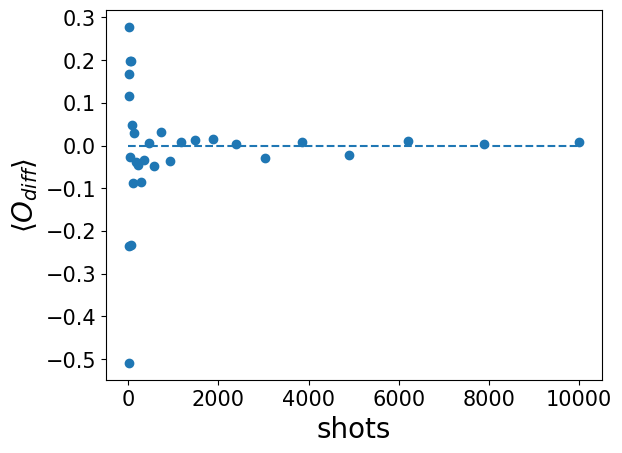

In [25]:
shot_list = np.round(np.geomspace(10, 10000, 30))
expectation_list = []

for shots in shot_list:
    expectation = estimate_with_shots(qc, O_diff, shots)
    expectation_list.append(expectation)

plt.scatter(shot_list, expectation_list)
plt.ylabel(r'$\langle O_{diff}\rangle$', fontsize=20)
plt.xlabel('shots', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.hlines(0, 0, 10000, ls='dashed')
plt.show()

You should observe that the expectation value approaches 0 as the number of shots increase. In the ideal scenario where we have an infinitely number of shots, one expect exactly zero, since we have an even distribution of $|01\rangle$ and $|10\rangle$.

In practice, we should always have enough shots as it is crucial to simulation results. Having too little shots yield inaccurate results; while having too many shots will waste a lot resources.

## Part 3. Maxcut Problem

<div class="alert alert-block alert-success">

There is an important Mathematical problem called the Maximum cut: 

**Given a graph of n nodes, how do we cut the graph into two partitions such that the number of edges between the two partitions are maximized?**

</div>

<div class="alert alert-block alert-success">

This is the so-called Maxcut problem, which is an NP-hard problem in general. It has excited many algorithms to calcuate its solution. In general, a bruteforce that enumerate all possible partitions will break down at large graph limit. So people have dived into approximation algorithms to solve this combinatorial problem. It has become an important subfield in Discrete Mathematics.

</div>

With the advent of quantum computing, Maxcut has been applied extensively using variational quantum algorithms and for some specific subfield of this interesting problem, the quantum approach seems to beat the classical approach. 

Today, we will look at the formulation of an ideal Maxcut problem (i.e., no constraints, no edge weight, etc), and we will use one of the popular quantum simulation techniques, the variational quantum algorithm, to solve this problem by ourselves.

We start by loading the networkx module and some helper functions...

In [26]:
# make sure networkx is installed, if not you can use Pip to install it, pip install networkx
import networkx as nx

In [27]:
# load helpful functions
def prepare_maxcut(n, edges):
    '''
    n: number of nodes in G
    edges: list of connected edge pairs in G, make sure edges are indexed from 0, 1, to (n-1)
    '''
    for ei, ej in edges:
        assert 0 <= ei < n and 0 <= ej < n, f"Invalid edges! Edge ({ei}, {ej}) is Not allowed in a {n}-node Graph."
    G = nx.Graph()
    G.add_nodes_from(np.arange(0, n, 1))
    G.add_edges_from(edges)
    pos = nx.shell_layout(G)  # fix plot position, more options see 
    return G, pos

def plot_maxcut(G, pos, colors=None):
    '''
    Plot the Maxcut problem instance
    '''
    if colors == None:
        colors = ["lightgray" for node in G.nodes()]
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=1000, alpha=1.0, ax=default_axes, pos=pos)
    nx.draw_networkx_edges(G, pos=pos)
    
def get_adj_matrix(G):
    '''
    Return an adjacency matrix of G, representing w_ij
    '''
    w = np.zeros([n, n])
    for i in range(n):
        for j in range(n):
            temp = G.get_edge_data(i, j, default=0)
            if temp != 0:
                w[i, j] = 1
    return w

def get_bruteforce_sol(G, verbose=False):
    '''
    Return the bruteforce solution for the adjacency matrix of a Maxcut graph.
    '''
    G_adj = get_adj_matrix(G)
    best_cost_brute = 0
    for b in range(2**n):
        # b = 0, x = [0, 0, 0, 0]
        # b = 1, x = [1, 0, 0, 0]
        # b = 2, x = [0, 1, 0, 0] ...
        x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
        cost = 0
        for i in range(n):
            for j in range(n):
                cost = cost + G_adj[i, j] * x[i] * (1 - x[j])
        if best_cost_brute < cost:
            best_cost_brute = cost
            xbest_brute = x
        if verbose: print("case = " + str(x) + " cost = " + str(cost))
    return xbest_brute, best_cost_brute

<div class="alert alert-block alert-success">

### **Exercise 6. Play with Maxcut problem**  
    
Play with these functions above 
- *prepare_maxcut*  
- *plot_maxcut*      
- *get_adj_matrix*   
- *get_bruteforce_sol*

See if you can come up with an interesting Maxcut problem and solve it by hand and then by the program. 
    
Warning, be careful with the number of nodes, n, in the Graph. Your computer might crash if n is too big.

</div>

Adjacency matrix W = 
 [[0. 1. 0. 1.]
 [1. 0. 1. 0.]
 [0. 1. 0. 1.]
 [1. 0. 1. 0.]]


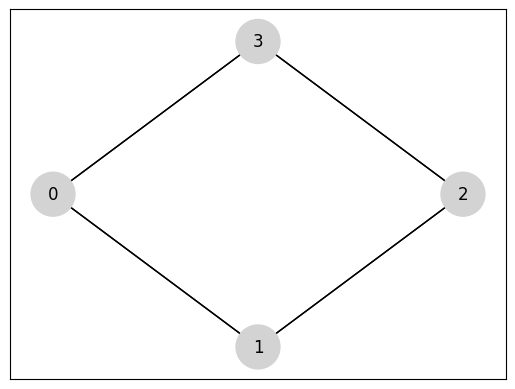

In [28]:
# Example 1.
n = 4
edges = [[0, 1], [1, 2], [2, 3], [3, 0]]
G, pos = prepare_maxcut(n, edges)
print("Adjacency matrix W = \n", get_adj_matrix(G))
plot_maxcut(G, pos)

case = [0, 0, 0, 0] cost = 0.0
case = [1, 0, 0, 0] cost = 2.0
case = [0, 1, 0, 0] cost = 2.0
case = [1, 1, 0, 0] cost = 2.0
case = [0, 0, 1, 0] cost = 2.0
case = [1, 0, 1, 0] cost = 4.0
case = [0, 1, 1, 0] cost = 2.0
case = [1, 1, 1, 0] cost = 2.0
case = [0, 0, 0, 1] cost = 2.0
case = [1, 0, 0, 1] cost = 2.0
case = [0, 1, 0, 1] cost = 4.0
case = [1, 1, 0, 1] cost = 2.0
case = [0, 0, 1, 1] cost = 2.0
case = [1, 0, 1, 1] cost = 2.0
case = [0, 1, 1, 1] cost = 2.0
case = [1, 1, 1, 1] cost = 0.0

Best solution = [1, 0, 1, 0]  Maxcut cost = 4.0


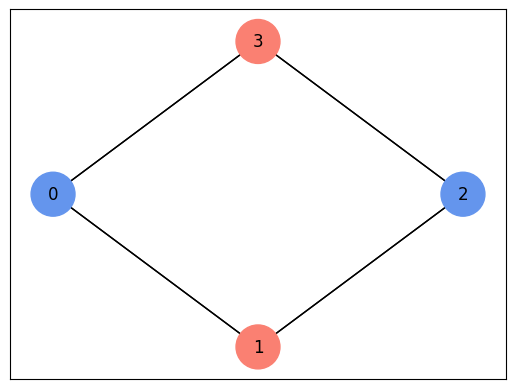

In [29]:
xbest_brute, best_cost_brute = get_bruteforce_sol(G, verbose=True)
print("\nBest solution = " + str(xbest_brute) + "  Maxcut cost = " + str(best_cost_brute))
colors = ["salmon" if xbest_brute[i] == 0 else "cornflowerblue" for i in range(n)]
plot_maxcut(G, pos, colors)

Adjacency matrix W = 
 [[0. 1. 0. 1. 0. 1.]
 [1. 0. 1. 1. 0. 0.]
 [0. 1. 0. 1. 0. 0.]
 [1. 1. 1. 0. 1. 1.]
 [0. 0. 0. 1. 0. 1.]
 [1. 0. 0. 1. 1. 0.]]


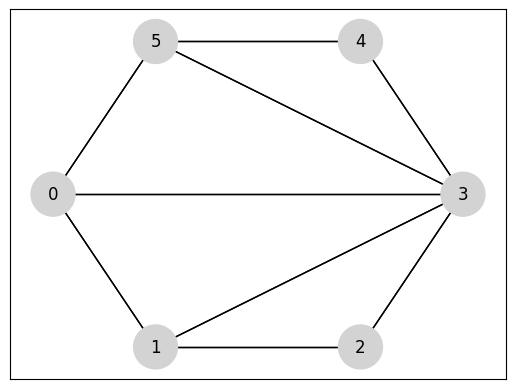

In [30]:
# Example 2.
n = 6
edges = [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 0], [3, 0], [1, 3], [3, 5]]
G, pos = prepare_maxcut(n, edges)
print("Adjacency matrix W = \n", get_adj_matrix(G))
plot_maxcut(G, pos)

case = [0, 0, 0, 0, 0, 0] cost = 0.0
case = [1, 0, 0, 0, 0, 0] cost = 3.0
case = [0, 1, 0, 0, 0, 0] cost = 3.0
case = [1, 1, 0, 0, 0, 0] cost = 4.0
case = [0, 0, 1, 0, 0, 0] cost = 2.0
case = [1, 0, 1, 0, 0, 0] cost = 5.0
case = [0, 1, 1, 0, 0, 0] cost = 3.0
case = [1, 1, 1, 0, 0, 0] cost = 4.0
case = [0, 0, 0, 1, 0, 0] cost = 5.0
case = [1, 0, 0, 1, 0, 0] cost = 6.0
case = [0, 1, 0, 1, 0, 0] cost = 6.0
case = [1, 1, 0, 1, 0, 0] cost = 5.0
case = [0, 0, 1, 1, 0, 0] cost = 5.0
case = [1, 0, 1, 1, 0, 0] cost = 6.0
case = [0, 1, 1, 1, 0, 0] cost = 4.0
case = [1, 1, 1, 1, 0, 0] cost = 3.0
case = [0, 0, 0, 0, 1, 0] cost = 2.0
case = [1, 0, 0, 0, 1, 0] cost = 5.0
case = [0, 1, 0, 0, 1, 0] cost = 5.0
case = [1, 1, 0, 0, 1, 0] cost = 6.0
case = [0, 0, 1, 0, 1, 0] cost = 4.0
case = [1, 0, 1, 0, 1, 0] cost = 7.0
case = [0, 1, 1, 0, 1, 0] cost = 5.0
case = [1, 1, 1, 0, 1, 0] cost = 6.0
case = [0, 0, 0, 1, 1, 0] cost = 5.0
case = [1, 0, 0, 1, 1, 0] cost = 6.0
case = [0, 1, 0, 1, 1, 0] cost = 6.0
c

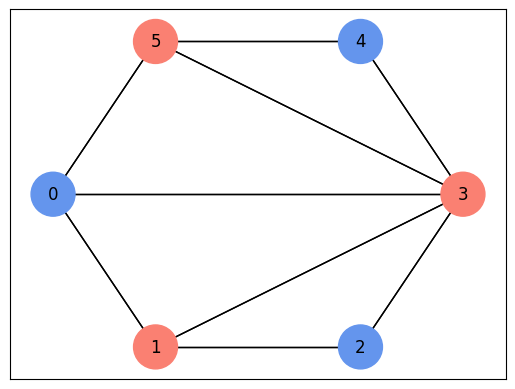

In [31]:
xbest_brute, best_cost_brute = get_bruteforce_sol(G, verbose=True)
print("\nBest solution = " + str(xbest_brute) + "  Maxcut cost = " + str(best_cost_brute))
colors = ["salmon" if xbest_brute[i] == 0 else "cornflowerblue" for i in range(n)]
plot_maxcut(G, pos, colors)

Best solution = [1, 0, 1, 1, 0, 1, 0, 0]  Maxcut cost = 13.0


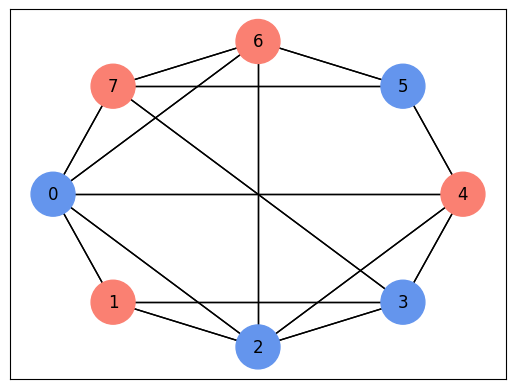

In [32]:
# Example 3.
n = 8
edges = [[i, i+1] for i in range(0, n-1)] + [[n-1, 0]]
edges += [[0, 2], [1, 3], [2, 4], [3, 7], [2, 6], [3,4], [6,7], [5,7], [0, 4], [0, 6]]
G, pos = prepare_maxcut(n, edges)
xbest_brute, best_cost_brute = get_bruteforce_sol(G)
print("Best solution = " + str(xbest_brute) + "  Maxcut cost = " + str(best_cost_brute))
colors = ["salmon" if xbest_brute[i] == 0 else "cornflowerblue" for i in range(n)]
plot_maxcut(G, pos, colors)

Did you come up with something more interesting?

<div class="alert alert-block alert-success">

### **Exercise 7. Building the Maxcut Hamiltonian**  
    
From the lecture, we know the Maxcut Hamiltonian looks like,
    
$$    H = \sum_{ij} w_{ij}x_i(1-x_j) = \sum_{ij} w_{ij}\frac{I_i-Z_i}{2}\Big(I- \frac{I_j-Z_j}{2}\Big) = \sum_{i} c_{i} Z_i + \sum_{ij} d_{ij} Z_iZ_j$$
    
Use the helper function below (or come up with your own) to build the Hamiltonian for Maxcut.
    
Important to verify, your final, simplied Hamiltonian must only contain Pauli Z expressions.
</div>

In [33]:
# helpful functions
def get_x_op_at_i(i, n):
    ''' Return an operator (I-Z)/2 at specified qubit index i, with n qubits in total '''
    candidates = [I]*n
    candidates[i] = (I - Z)/2
    res = candidates[0]
    for i in range(1, n):
        res = res^candidates[i]
    return res

def get_I_op(n):
    ''' Return an identity operator over n qubits'''
    return SparsePauliOp(["I"*n], [1])

print(get_x_op_at_i(1, 4))
print(get_I_op(4))

SparsePauliOp(['IIII', 'IZII'],
              coeffs=[ 0.5+0.j, -0.5+0.j])
SparsePauliOp(['IIII'],
              coeffs=[1.+0.j])


In [34]:
def get_Hamiltonian_of_graph(G):
    '''
    Get Pauli-ZZ Hamiltonian for the adjacency matrix of a graph
    '''
    G_adj = get_adj_matrix(G)
    n = len(G_adj)
    Hamiltonian = 0

    for i in range(n):
        for j in range(n):
            if G_adj[i][j] != 0: # to speed up, avoid 0
                ##### ==================================
                # Write your solution in here.  
                # basically, you try to add all nonzero pauli terms to the Hamiltonian variable
                # each pauli term is a product of two pauli operator
                
                Hamiltonian = Hamiltonian + G_adj[i, j] * get_x_op_at_i(i, n) @ (get_I_op(n) - get_x_op_at_i(j, n))
                
                ##### ==================================
                
    Hamiltonian = Hamiltonian.simplify()  # simplify algebraic expression
    return Hamiltonian

SparsePauliOp(['IIII', 'ZZII', 'ZIIZ', 'IZZI', 'IIZZ'],
              coeffs=[ 2. +0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j])


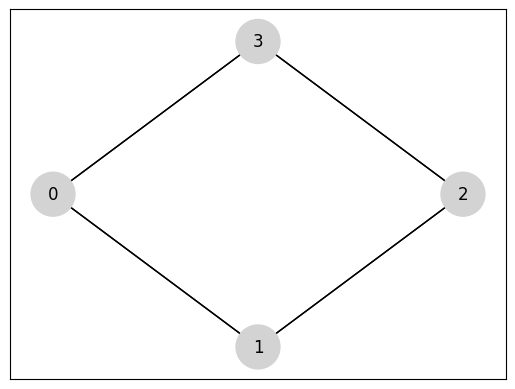

In [35]:
# Verification, Hamiltonian must contain only Pauli-Z
# Try start with a simple graph first, then move to a larger graph.
n = 4
edges = [[0, 1], [1, 2], [2, 3], [3, 0]]
G, pos = prepare_maxcut(n, edges)
H = get_Hamiltonian_of_graph(G)
print(H)
plot_maxcut(G, pos)

## Part 4. Variational Quantum Eigensolver

<div class="alert alert-block alert-success">

### **Exercise 8. Vartional Quantum Eigensolver, part 1**  
    
With the Hamiltonian defined, we know the solution to the Maxcut problem is the ground state of the Hamiltonian. To obtain the ground state, we use the Vartional Quantum Eigensolver (VQE). The VQE optimization loop consists of three essential parts

- Variational ansatz

- Quantum evolution and expectation evaluation, i.e. $\langle H \rangle = \langle \psi | H | \psi \rangle $
    
- Classical optimizer to update the next parameter, or exit the loop.
    
The following exercises will teach you build the VQE one by one, from scratch.
    
</div>

<div class="alert alert-block alert-success">

We first look at the **variational ansatz**. 

For this part, we use the so-called Two-Local ansatz (available as *TwoLocal* class from Qiskit), where only adjacent qubit are connected (entangled). It is a commonly-used hardware-efficient ansatz, commonly used in quantum optimization problems.
    
</div>

In [36]:
from qiskit.circuit.library import TwoLocal

Here is an example on how to build 4-qubit TwoLocal ansatz with "ry" rotation gates, "cz" entanglement gates, and a depth of 5 repeated layers, which is a good starting place for us.

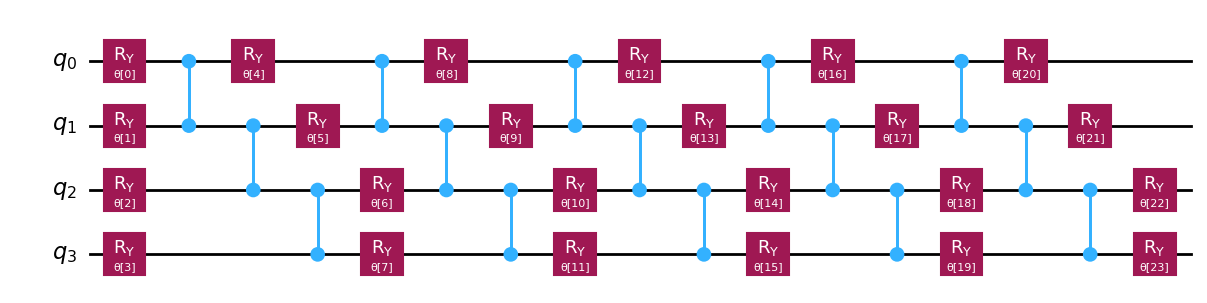

In [37]:
ansatz = TwoLocal(4, "ry", "cz", reps=5, entanglement="linear")
ansatz.decompose().draw(output='mpl')

Play with the parameters above to generate different circuit. 

In [38]:
ansatz.parameters

ParameterView([ParameterVectorElement(θ[0]), ParameterVectorElement(θ[1]), ParameterVectorElement(θ[2]), ParameterVectorElement(θ[3]), ParameterVectorElement(θ[4]), ParameterVectorElement(θ[5]), ParameterVectorElement(θ[6]), ParameterVectorElement(θ[7]), ParameterVectorElement(θ[8]), ParameterVectorElement(θ[9]), ParameterVectorElement(θ[10]), ParameterVectorElement(θ[11]), ParameterVectorElement(θ[12]), ParameterVectorElement(θ[13]), ParameterVectorElement(θ[14]), ParameterVectorElement(θ[15]), ParameterVectorElement(θ[16]), ParameterVectorElement(θ[17]), ParameterVectorElement(θ[18]), ParameterVectorElement(θ[19]), ParameterVectorElement(θ[20]), ParameterVectorElement(θ[21]), ParameterVectorElement(θ[22]), ParameterVectorElement(θ[23])])

In [39]:
len(ansatz.parameters)

24

Importantly, how many parameters do you see in the variational ansatz you built (by calling the *ansatz.parameters*)?

Let's write a function to build an ansatz for graph of any node size $n$ and an arbitrary number of layers.

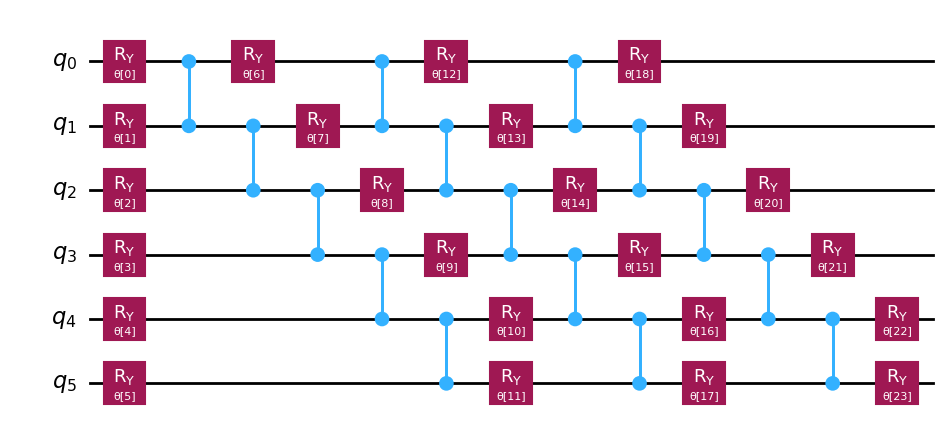

In [40]:
# build our own function using the example above 
def get_ansatz(n, layers):
    ##### ==================================
    # Write your solution in here.  
    ansatz = TwoLocal(n, "ry", "cz", reps=layers, entanglement="linear")
    ##### ==================================
    return ansatz

# test
empty_ansatz = get_ansatz(6, 3)
empty_ansatz.decompose().draw(output='mpl')

Importantly, the ansatz you just built are without any specified parameters. To bind your variational circuit with some parameters. Use the *assign_parameters()* functions.

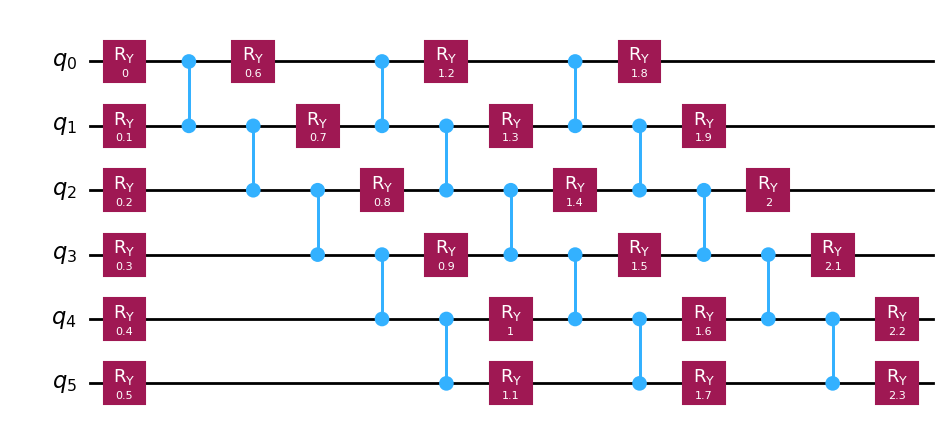

In [41]:
num_params = empty_ansatz.num_parameters

binded_ansatz = empty_ansatz.assign_parameters([0.1*i for i in range(num_params)]) # input parameters need to match the dimension of ansatz parameters

binded_ansatz.decompose().draw(output='mpl')

<div class="alert alert-block alert-success">

### **Exercise 9. Vartional Quantum Eigensolver, part 2**  
    
We now look at evaluating the expectation, i.e., measuring the observable.
    
We write an *get_expectation* function to take in a variantional ansatz, a list of parameters, an observable, and a shot number. It returns the expectation value. 
    
Try take advantage of our own function *estimate_with_shots* defined earlier.
    
Note, the ansatz qubits and the observable qubits must be the identical.
        
</div>

In [42]:
def get_expectation(ansatz, params, observable, shots):
    assert ansatz.num_qubits == observable.num_qubits, f"ansatz qubits = {ansatz.num_qubits}, observable qubits = {observable.num_qubits}"
    assert len(params) == ansatz.num_parameters
    ##### ==================================
    # Write your solution in here.  
    circuit = ansatz.assign_parameters(params)
    expectation = estimate_with_shots(circuit, observable, shots)
    ##### ==================================
    return expectation

In [43]:
# test
# maxcut problem instance
n = 4
edges = [[0, 1], [1, 2], [2, 3], [3, 0]]
G, pos = prepare_maxcut(n, edges)

# building ansatz and observable
ansatz_ex = get_ansatz(n, 3)
parameters = [0.1]*ansatz_ex.num_parameters
observable = get_Hamiltonian_of_graph(G)

# expectation
get_expectation(ansatz_ex, parameters, observable, 1000)

np.float64(0.31051752711381964)

Note, your *get_expectation* function should return a single value, which is the expectation value of quantum state generated by the ansatz. By tuning the parameters, you will see that this expectation value is different.

Interestingly, with fixed parameters, this function might also return something that is different each time. Try the following test.

In [44]:
shots = 1000
for i in range(10):
    val = get_expectation(ansatz_ex, parameters, observable, shots)
    print(f'run {i} expectation = {val:>.10}')

run 0 expectation = 0.2767787721
run 1 expectation = 0.2985472037
run 2 expectation = 0.2787550262
run 3 expectation = 0.2915055345
run 4 expectation = 0.3200212583
run 5 expectation = 0.3084307573
run 6 expectation = 0.3238954926
run 7 expectation = 0.2645227036
run 8 expectation = 0.3447157895
run 9 expectation = 0.3205099052


This is because of shot uncertainties. Try using a significantly larger number of shots and see what happens :)

Essentially, the VQE algorithm will find the optimal parameter of the ansatz when this expectation value is minimized. By the Variational Principle, when the expectation minimizes, our guess wavefunction approaches the ideal wavefunction, and thus becomes the ground state of the target Hamiltonian

In short, your ansatz with optimal parameters becomes your ideal wavefunction.

<div class="alert alert-block alert-success">

### **Exercise 10. Vartional Quantum Eigensolver, part 3**  
    
We now look at the last step, which is the optimization using classical optimizer, to complete our VQE function.
    
Our *vqe_from_scratch* takes a Maxcut problem instance G, a variational ansatz, and number of shots.
    
Specifically, we use Qiskit's *COBYLA* optimizers. Since *COBYLA* only has a *minimize* method, and we try to maximize the expectation observable (because it is called Maxcut!), we should evaluate $-\langle H \rangle$ in the *COBYLA.minimize* method. Maximum iterations, i.e., *maxiter*, should also be supplied.
        
To make results somewhat comparable, we add *random_seed* argument for initializing the parameter. However, simulation itself still involves randomness (a topic for another day).

There are a lot of optimizers you can use if you are interested, available in [qiskit.algorithms.optimizers](https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.html). If you are using other classes, call_back functions need modify, see comments within.
</div>

In [45]:
from qiskit_algorithms.optimizers import COBYLA
# from qiskit.algorithms.optimizers import COBYLA # if last line does not work, use this one (but I recommend first line)

def maxcut_vqe_from_scratch(G, ansatz, shots, maxiter=300, random_seed=0, verbose=True):
    '''
    Our VQE from scratch for Maxcut problem G
    
    Return the VQE optimization result and its history
    
    '''
    
    # Helper function
    exp_val_list = []
    def callback(params):
        '''
        Callback to record expectation history and more!
           It is always optimizer dependent, so very tricky in general, for other optimizers, 
           you will need modify the argument to callback(num_eval, param, f_eval, step, acc) instead
        '''
        exp_val = get_expectation(ansatz, params, observable, shots)
        exp_val_list.append(exp_val)
        if verbose == True: print(f"step {len(exp_val_list):>4}:  <H> = {exp_val:>6.3f}")
    
    initial_parameters = [0.1]*ansatz.num_parameters
    observable = get_Hamiltonian_of_graph(G)
    
    def minimize_func(params):
        ##### ==================================
        # Write your solution in here.     
        value_to_maximize = - get_expectation(ansatz, params, observable, shots)
        ##### ==================================
        return value_to_maximize

    np.random.seed(random_seed)
    initial_params = 0.1* np.random.random(ansatz.num_parameters)
    opt = COBYLA(maxiter=maxiter, callback=callback)
    
    res = opt.minimize(minimize_func, initial_params)
    
    return res, exp_val_list

In [46]:
# test
# maxcut problem instance
n = 4
edges = [[0, 1], [1, 2], [2, 3], [3, 0]]
G, pos = prepare_maxcut(n, edges)

# building ansatz and observable
ansatz = get_ansatz(n, 1)

# vqe
opt_res, exp_val_list = maxcut_vqe_from_scratch(G, ansatz, shots=1000)

step    1:  <H> =  0.555
step    2:  <H> =  0.973
step    3:  <H> =  1.307
step    4:  <H> =  1.604
step    5:  <H> =  2.186
step    6:  <H> =  2.342
step    7:  <H> =  2.562
step    8:  <H> =  2.575
step    9:  <H> =  2.303
step   10:  <H> =  2.447
step   11:  <H> =  2.617
step   12:  <H> =  2.331
step   13:  <H> =  2.681
step   14:  <H> =  2.540
step   15:  <H> =  2.629
step   16:  <H> =  2.743
step   17:  <H> =  2.893
step   18:  <H> =  2.803
step   19:  <H> =  2.834
step   20:  <H> =  2.793
step   21:  <H> =  2.804
step   22:  <H> =  2.774
step   23:  <H> =  2.871
step   24:  <H> =  2.824
step   25:  <H> =  2.738
step   26:  <H> =  2.854
step   27:  <H> =  2.763
step   28:  <H> =  2.808
step   29:  <H> =  2.777
step   30:  <H> =  2.788
step   31:  <H> =  2.758
step   32:  <H> =  2.764
step   33:  <H> =  2.807
step   34:  <H> =  2.780
step   35:  <H> =  2.821
step   36:  <H> =  2.761
step   37:  <H> =  2.810
step   38:  <H> =  2.732
step   39:  <H> =  2.801
step   40:  <H> =  2.822


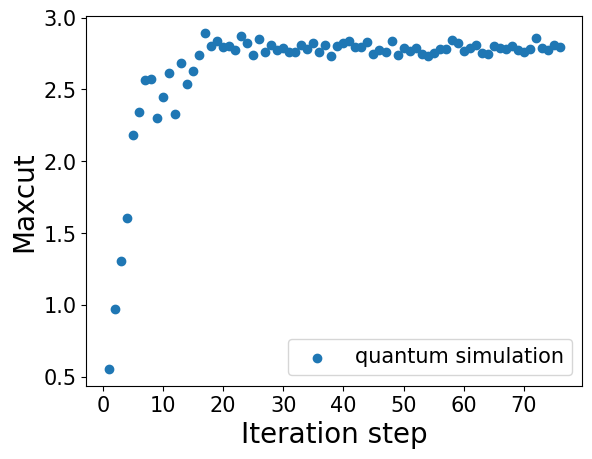

In [47]:
def plot_vqe_exp_val_list(exp_val_list, G=None):
    N = len(exp_val_list)
    xs = np.arange(1, N+1)
    plt.scatter(xs, exp_val_list, label='quantum simulation')
    plt.ylabel(r'Maxcut', fontsize=20)
    plt.xlabel('Iteration step', fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    if G != None:
        xBest, costBest = get_bruteforce_sol(G)
        plt.hlines(costBest, 0, N, ls='dashed', color='red', label='bruteforce')
    plt.legend(fontsize=15)
    plt.show()
    
# visualize result   
plot_vqe_exp_val_list(exp_val_list)

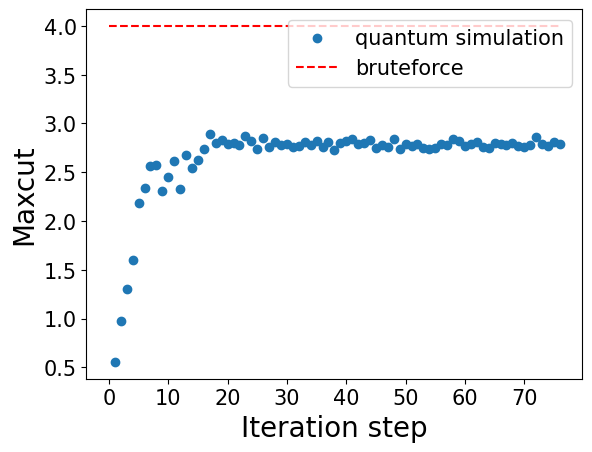

In [48]:
# visualize with bruteforce
plot_vqe_exp_val_list(exp_val_list, G)

If you see your simulation result agrees with the bruteforce as step increases, that indicates your algorithm is correct!

Big congratulations! You have implemented VQE from scratch, essentially.

<div class="alert alert-block alert-success">

### **Exercise 11. Vartional Quantum Eigensolver, part 4**  
    
Hopefully your VQE optimization is working and you obtain the expected result with bruteforce calculation. Congratulations! It is a big step.
    
Now, you may wonder how do I know my optimal solution, i.e., the binary variable $x$? Afterall, we also need to know how to partition the graph, where the maximum cut is reached? 
    
The answer is you just need to sample the quantum state with your final, optimal parameters of the ansatz! Use your *sample_with_shots* or *sample_with_shots_v2* class defined before.
</div>

In [49]:
# your optimal parameters is in the x method of your opt_res object
opt_res.x

array([1.28814713, 0.93035876, 1.24182298, 1.10154748, 0.96608293,
       0.6385351 , 1.18400475, 0.06941394])

In [50]:
def sample_probability_dist(ansatz, optimization_result, shots):
    num_qubits = ansatz.num_qubits
    ##### ==================================
    # Write your solution in here. 
    optimal_param = optimization_result.x
    qc = ansatz.assign_parameters(optimal_param)
    qc.measure_all()
    dist = sample_with_shots(qc, shots, num_qubits)
    ##### ==================================
    return dist

{'0111': 0.0361328125, '0010': 0.16015625, '0101': 0.380859375, '1001': 0.158203125, '1110': 0.041015625, '1000': 0.0283203125, '0100': 0.0966796875, '0001': 0.0458984375, '1011': 0.0146484375, '1010': 0.0302734375, '1100': 0.001953125, '0110': 0.0048828125, '0000': 0.0009765625}


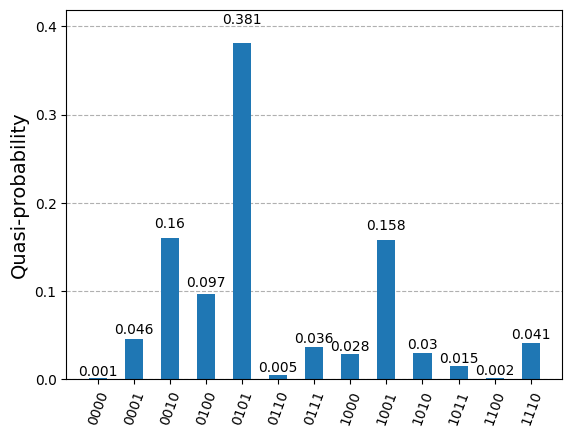

In [51]:
dist = sample_probability_dist(ansatz, opt_res, 1024)
print(dist)
plot_histogram(dist)
# plot_probability_dist(dist)

Note both 0101 and 1010 are correct solutions, because it does not matter if you call which one in partition which. It is just a label. So we literally achieved nearly 100 % accuracy!

Now, checking with bruteforce solution : )

Best solution = [1, 0, 1, 0]  Maxcut cost = 4.0


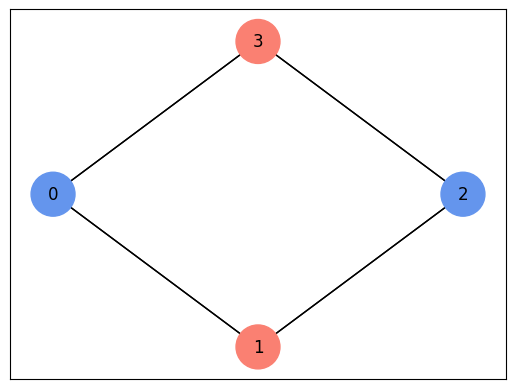

In [52]:
# cross check with bruteforce
xbest_brute, best_cost_brute = get_bruteforce_sol(G, verbose=False)
print("Best solution = " + str(xbest_brute) + "  Maxcut cost = " + str(best_cost_brute))
colors = ["salmon" if xbest_brute[i] == 0 else "cornflowerblue" for i in range(n)]
plot_maxcut(G, pos, colors)

In [53]:
# You can use my function to generate a random maxcut graph of n nodes and desired node connectivity.
def prepare_random_maxcut(n, connectivity=0.3):
    '''
    Some hard maxcut graph generator, not an ideal one
    '''
    assert 0 <= connectivity < 1, "Connectivity is between 0 and 1"
    edges = []
    for i in range(n):
        for j in range(n):
            if i == j: continue
            e, re = [i, j], [j, i]
            if re in edges: continue # can be optimized with cache
            if np.random.random() < connectivity:
                edges.append(e)
    G, pos = prepare_maxcut(n, edges)
    return G, pos

## Part 5. Quantum Approximation Optimization Algorithm

<div class="alert alert-block alert-success">

### **Exercise 12. Quantum Approximation Optimization Algorithm, part 1**  
    
Another promising variational approach to tackle the problem of finding the ground state and its energy is the Quantum Approximation Optimization Algorithm (QAOA). Like VQE, the QAOA is also an variational approach, consist of the same three steps.

The main difference is that QAOA approach takes inspiration of the Hamiltonian operators, with special emphasis on the type of variational ansatzes used in the simulation. 

The QAOA begins with an initialization circuit. Instead of using an arbitrary heuristic ansatz, the QAOA uses a problem-inspired ansatz made up of the following two individual parts for each layers:

1. Initialization circuit
   
- Variational ansatz of many layers
  2. Ansatz for Problem Hamitlonian
  3. Ansatz for Mixer Hamiltonian

The following exercises will teach you build the ansatz for QAOA one by one, from scratch.

First, we look at how to initialize the QAOA circuit. This is done by applying the Hadamard gate on each qubit.
    
</div>

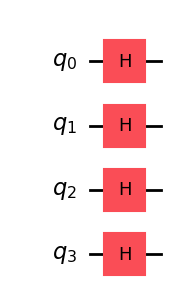

In [54]:
def initialize_circuit(n):
    ##### ==================================
    # Write your solution in here.  
    qc = QuantumCircuit(n)
    qc.h(range(n))
    ##### ==================================  
    return qc

#test
n = 4
initialize_circuit(n).draw()

<div class="alert alert-block alert-success">

### **Exercise 13. Quantum Approximation Optimization Algorithm, part 2**  
    
Now for the variational ansatz. Unlike VQE, the ansatz for QAOA consists of a problem Hamiltonian and mixer Hamiltonian. The problem Hamiltonian is *directly* inspired by the physical problem. 

For simplicity, we can build one that is just the time evolution of the Hamitlonian for the Maxcut problem.
    
</div>

SparsePauliOp(['IIII', 'ZIZI', 'ZIIZ', 'IZZI', 'IIZZ'],
              coeffs=[ 2. +0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j])


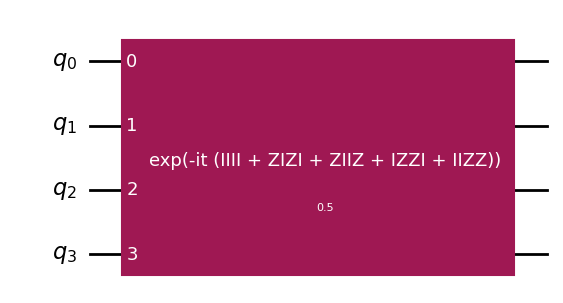

In [55]:
def problem_ansatz(n, H_op, angle):
    ##### ==================================
    # Write your solution in here.  
    qc = time_evolve(H_op, angle)
    ##### ==================================  
    return qc

#test
n = 4
G, pos = prepare_random_maxcut(n, connectivity=0.5)
H_op = get_Hamiltonian_of_graph(G)
print(H_op)
angle = 0.5
problem_ansatz(n, H_op, angle).draw()

<div class="alert alert-block alert-success">

### **Exercise 14. Quantum Approximation Optimization Algorithm, part 3**  
    
For the Mixer Hamiltonian, it can also be very versatile. In general, one would want it to non-commute with the problem Hamiltonian to make its way to the optimal solution. 

Usually we use rotational-X gates.
    
</div>

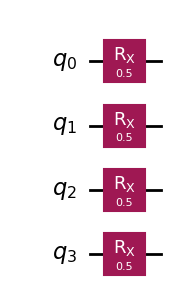

In [56]:
def mixer_ansatz(n, angle):
    ##### ==================================
    # Write your solution in here.  
    qc = QuantumCircuit(n)
    qc.rx(angle, range(n))
    ##### ==================================  
    return qc

#test
n = 4
angle = 0.5
mixer_ansatz(n, angle).draw()

<div class="alert alert-block alert-success">

### **Exercise 15. Quantum Approximation Optimization Algorithm, part 4**  
    
Now, put together your problem ansatz and your mixer ansatz to build the QAOA ansatz for your Maxcut problem!
    
</div>

SparsePauliOp(['IIII', 'ZIZI', 'ZIIZ', 'IZZI'],
              coeffs=[ 1.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j])


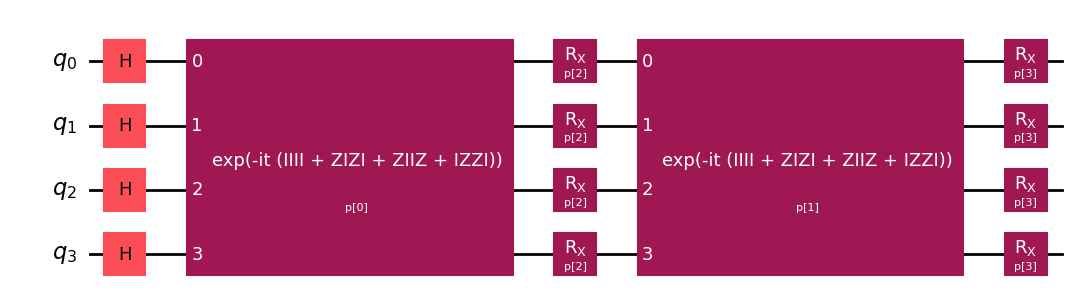

In [57]:
# build our own function using the example above 
def get_QAOA_ansatz(n, H_op, layers):
    qc = QuantumCircuit(n)
    # initialization circuit
    qc.append(initialize_circuit(n), range(n))

    params = ParameterVector('p', length=2*layers)
    
    for i in range(layers):
    ##### ==================================
    # Write your solution in here.          
        qc.append(problem_ansatz(n, H_op, params[i]), range(n))
        qc.append(mixer_ansatz(n, params[layers+i]), range(n))
    ##### ==================================
    return qc

# test
n = 4
layers = 2
G, pos = prepare_random_maxcut(n, connectivity=0.5)
H_op = get_Hamiltonian_of_graph(G)
print(H_op)

empty_ansatz = get_QAOA_ansatz(n, H_op, layers)
empty_ansatz.decompose().draw(output='mpl')

Importantly, the ansatz you just built are without any specified parameters. To bind your variational circuit with some parameters. Use the *bind_parameters()* functions.

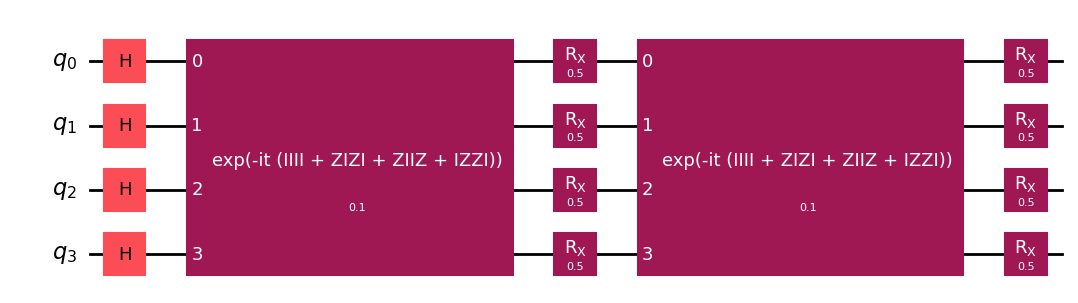

In [58]:
num_params = empty_ansatz.num_parameters

binded_ansatz = empty_ansatz.assign_parameters([0.1]*layers+[0.5]*layers) # input parameters need to match the dimension of ansatz parameters

binded_ansatz.decompose().draw(output='mpl')

<div class="alert alert-block alert-success">

Let us test and compare your VQE and QAOA ansatz performance on some interesting graphs!

</div>

Best solution = [1, 1, 0, 1, 0, 0, 0, 0]  Maxcut cost = 11.0


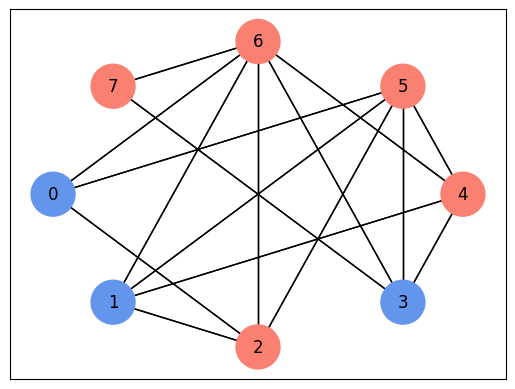

In [59]:
# test
# maxcut problem instance
n = 8
G, pos = prepare_random_maxcut(n, 0.3)
H_op = get_Hamiltonian_of_graph(G)
xbest_brute, best_cost_brute = get_bruteforce_sol(G)
print("Best solution = " + str(xbest_brute) + "  Maxcut cost = " + str(best_cost_brute))
colors = ["salmon" if xbest_brute[i] == 0 else "cornflowerblue" for i in range(n)]
plot_maxcut(G, pos, colors)

# n = 4
# edges = [[0, 1], [1, 2], [2, 3], [3, 0]]
# G, pos = prepare_maxcut(n, edges)


In [60]:
random_seed = 10
maxiter = 1000
shots   = 8000

# vqe
layers = 2
vqe_ansatz = get_ansatz(n, layers)
vqe_opt_res, vqe_exp_val_list = maxcut_vqe_from_scratch(G, vqe_ansatz, shots=shots, verbose=False, maxiter=maxiter, random_seed=random_seed)
print(f'VQE finishes, total params = {layers*n*2}')

# qaoa
layers = 5
qaoa_ansatz = get_QAOA_ansatz(n, H_op, layers)
qaoa_opt_res, qaoa_exp_val_list = maxcut_vqe_from_scratch(G, qaoa_ansatz, shots=shots, verbose=False, maxiter=maxiter, random_seed=random_seed)
print(f'QAOA finishes, total params = {layers*2}')


VQE finishes, total params = 32
QAOA finishes, total params = 10


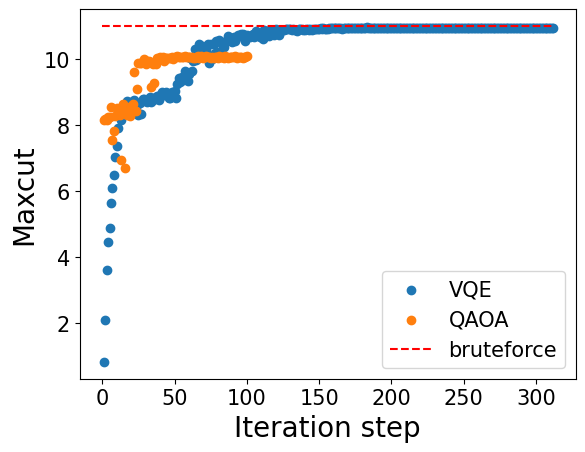

In [61]:
def plot_multiple_exp_val_list(exp_val_lists, labels, G=None):
    max_N = 0
    for i, exp_val_list in enumerate(exp_val_lists):
        N = len(exp_val_list)
        max_N = max(max_N, N)
        xs = np.arange(1, N+1)
        plt.scatter(xs, exp_val_list, label=labels[i])
    plt.ylabel(r'Maxcut', fontsize=20)
    plt.xlabel('Iteration step', fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    if G != None:
        xBest, costBest = get_bruteforce_sol(G)
        plt.hlines(costBest, 0, max_N, ls='dashed', color='red', label='bruteforce')
    plt.legend(fontsize=15)
    plt.show()
    
# visualize result   
plot_multiple_exp_val_list([vqe_exp_val_list, qaoa_exp_val_list], ['VQE', "QAOA"], G)

<div class="alert alert-block alert-success">

**(More Challenge) Improve your VQE/QAOA function to solve the Maxcut Problem**  
    
Play with your *maxcut_vqe_from_scratch* on a more complicated Maxcut problem to see how it behaves! At some point, for some graph, the algorithm becomes insufficient, indicating the room for improvement.
    
There are literally a million things you can improve from here. To name a few, optimizer, expectation evaluations, etc. I hope you enjoyed the short journey of quantum simulation. Feel free to let me know if you have any question.

</div>

Best solution = [0, 0, 1, 1, 0, 1, 0, 1, 0, 0]  Maxcut cost = 15.0


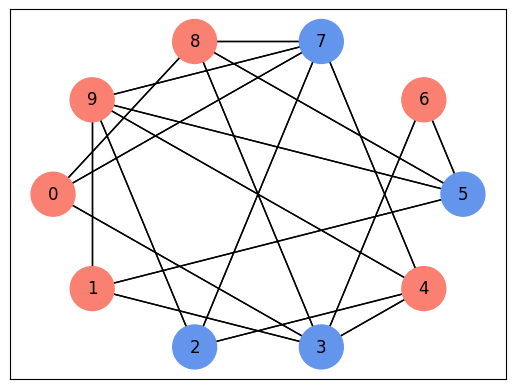

In [62]:
n = 10
G, pos = prepare_random_maxcut(n, 0.3)
xbest_brute, best_cost_brute = get_bruteforce_sol(G)
print("Best solution = " + str(xbest_brute) + "  Maxcut cost = " + str(best_cost_brute))
colors = ["salmon" if xbest_brute[i] == 0 else "cornflowerblue" for i in range(n)]
plot_maxcut(G, pos, colors)

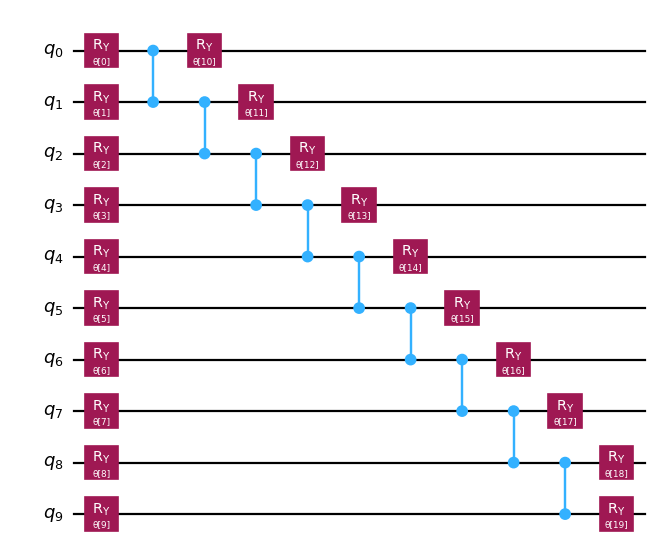

In [63]:
# building ansatz
ansatz = get_ansatz(n, 1)
ansatz.decompose().draw(scale=0.8, output='mpl')

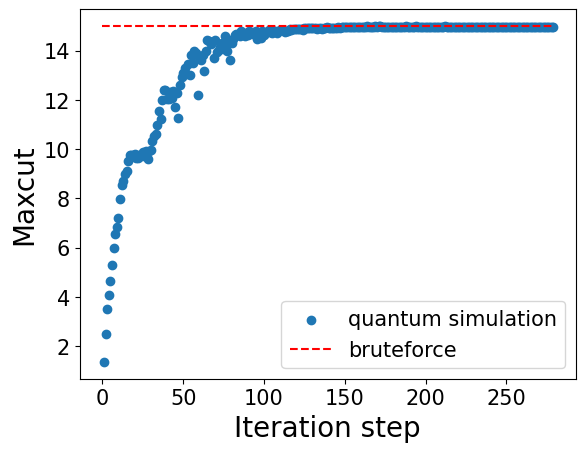

In [64]:
# vqe optimization
# taking verbose = True to see the evolutions (might be very long list)
opt_res, exp_val_list = maxcut_vqe_from_scratch(G, ansatz, shots=3000, maxiter=500, random_seed=42,
                                                verbose=False)
plot_vqe_exp_val_list(exp_val_list, G)